In [1]:
import gc
import numba
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

***

In [2]:
train = pd.read_parquet("../data/ext/amex-data-integer-dtypes-parquet-format/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv",)

In [3]:
all_cols = [c for c in list(train.columns) if c not in ['customer_ID','S_2']]
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
num_features = [col for col in all_cols if col not in cat_features]

In [4]:
len(num_features)

177

***

In [5]:
@numba.njit()
def compute_slope(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    return np.sum((x-x_mean)*(y-y_mean)) / np.sum((x-x_mean)**2)

In [6]:
def compute_slope_cols(df, customer_ID):
    n = len(df)
    if n > 2:
        x = np.arange(n)
        _df = df[num_features].fillna(method="ffill", axis=0).fillna(method="bfill", axis=0)
        r = _df[num_features].apply(lambda y: compute_slope(x, y.values))
        r = r.to_dict()
    else:
        r = df[num_features].apply(lambda y: 0)
        r = r.to_dict()
    r["customer_ID"] = customer_ID
    return r

In [7]:
with Parallel(n_jobs=8) as parallel:
        delayed_func = delayed(compute_slope_cols)
        results = parallel(
            delayed_func(df, customer_ID) 
            for customer_ID,df in tqdm(train.groupby("customer_ID"))
        )

100% 458913/458913 [12:01<00:00, 636.45it/s]


In [8]:
slopes = pd.DataFrame(results).fillna(0)
slopes

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,customer_ID
0,-0.002724,-0.065934,-0.000122,0.000219,-0.000304,-0.001293,0.000000,0.000079,0.0,0.000000,0.000000,-0.214286,0.002286,0.004115,0.0,0.013027,0.001544,0.006965,0.000000,0.010201,-0.002281,0.000000,0.000024,-0.225275,-0.000174,0.000000,-0.000230,-0.010146,0.035233,0.000000,-0.000420,0.000232,0.000000,0.0,0.0,-0.005062,-0.002853,-8.185714e+01,-0.013873,0.001097,-0.002652,0.0,-0.016019,-0.006148,-0.000688,-0.016484,0.041247,-0.000269,-0.000707,0.258242,0.021552,0.000000,0.000000,0.000000,0.040362,0.000000,0.000000,-0.014193,-0.000258,29.703297,0.000153,-0.000017,0.00000,0.000000,0.027940,0.0,0.131868,-0.002035,0.0,0.0,-1.153846e-01,-0.115385,0.0,0.000266,0.0,0.000134,0.000366,-0.000041,0.0,0.0,0.0,0.0,-0.000328,0.109890,0.0,0.000000,0.000326,0.0,0.0,0.000127,0.0,-0.002693,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000209,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.109890,-0.115385,0.000000,0.0,0.0,0.0,0.0,0.000994,-0.000201,0.000862,-0.000100,0.000009,0.014496,0.000000,0.000977,0.015304,0.0,0.000000,0.000184,0.000308,0.0,0.000054,0.0,0.0,0.0,0.0,0.0,0.000000,-0.013380,0.014429,0.000000e+00,0.001409,0.001683,0.001231,0.001343,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000408,0.000000,0.0,0.0,0.000000,0.000000,0.00000,-0.000366,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.000016,0.000000,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a
1,-0.004843,-0.071429,-0.000945,-0.003219,0.000062,0.005813,0.000000,0.000031,0.0,-0.052486,0.000000,-0.054945,0.002165,-0.004308,0.0,0.000667,0.001637,-0.003873,0.000000,-0.000546,-0.000791,0.000000,0.000000,-0.049451,-0.000108,0.115385,0.014582,-0.007080,0.000103,0.000000,-0.000447,-0.000807,0.000000,0.0,0.0,0.006558,0.000133,-9.856044e+01,-0.001610,0.000927,-0.001688,0.0,0.000079,0.004184,-0.000323,-0.032967,-0.004654,0.000570,0.000109,0.351648,-0.000220,0.000000,-0.148352,0.000000,0.000000,0.000000,0.000000,0.000423,0.000254,-9.560440,0.000128,-0.000036,0.00000,0.000000,-0.000209,0.0,0.159341,-0.000603,0.0,0.0,0.000000e+00,0.000000,0.0,0.000327,0.0,0.000231,-0.001442,-0.000018,0.0,0.0,0.0,0.0,0.000090,0.000000,0.0,0.005495,0.000016,0.0,0.0,0.000089,0.0,-0.000228,0.0,0.0,0.0,0.0,0.0,1.525032e-18,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000276,0.0,0.000000,0.0,0.032967,0.0,0.000000,0.0,0.0,0.0,-0.049451,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001031,0.000200,0.000732,-0.000154,-0.000203,-0.000120,0.000000,0.000000,0.000000,0.0,0.000000,-0.000088,-0.001332,0.0,0.000296,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000935,-0.014723,0.000000e+00,0.001789,0.001546,0.001893,0.001365,0.000000,0.000000,0.000000,0.000000,0.021978,-0.000084,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000449,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000183,0.000000,00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5
2,-0.000813,0.000000,0.000083,-0.000011,0.000118,0.000000,0.000000,0.000100,0.0,0.000000,0.010989,0.164835,0.002189,-0.000610,0.0,0.002827,0.001758,0.006253,0.000000,-0.001036,0.000413,0.000000,0.000000,0.109890,0.000031,0.

In [9]:
slopes_mrg = pd.merge(slopes, train_labels, how="inner", on="customer_ID")
slopes_mrg

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,customer_ID,target
0,-0.002724,-0.065934,-0.000122,0.000219,-0.000304,-0.001293,0.000000,0.000079,0.0,0.000000,0.000000,-0.214286,0.002286,0.004115,0.0,0.013027,0.001544,0.006965,0.000000,0.010201,-0.002281,0.000000,0.000024,-0.225275,-0.000174,0.000000,-0.000230,-0.010146,0.035233,0.000000,-0.000420,0.000232,0.000000,0.0,0.0,-0.005062,-0.002853,-8.185714e+01,-0.013873,0.001097,-0.002652,0.0,-0.016019,-0.006148,-0.000688,-0.016484,0.041247,-0.000269,-0.000707,0.258242,0.021552,0.000000,0.000000,0.000000,0.040362,0.000000,0.000000,-0.014193,-0.000258,29.703297,0.000153,-0.000017,0.00000,0.000000,0.027940,0.0,0.131868,-0.002035,0.0,0.0,-1.153846e-01,-0.115385,0.0,0.000266,0.0,0.000134,0.000366,-0.000041,0.0,0.0,0.0,0.0,-0.000328,0.109890,0.0,0.000000,0.000326,0.0,0.0,0.000127,0.0,-0.002693,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000209,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.109890,-0.115385,0.000000,0.0,0.0,0.0,0.0,0.000994,-0.000201,0.000862,-0.000100,0.000009,0.014496,0.000000,0.000977,0.015304,0.0,0.000000,0.000184,0.000308,0.0,0.000054,0.0,0.0,0.0,0.0,0.0,0.000000,-0.013380,0.014429,0.000000e+00,0.001409,0.001683,0.001231,0.001343,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000408,0.000000,0.0,0.0,0.000000,0.000000,0.00000,-0.000366,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.000016,0.000000,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
1,-0.004843,-0.071429,-0.000945,-0.003219,0.000062,0.005813,0.000000,0.000031,0.0,-0.052486,0.000000,-0.054945,0.002165,-0.004308,0.0,0.000667,0.001637,-0.003873,0.000000,-0.000546,-0.000791,0.000000,0.000000,-0.049451,-0.000108,0.115385,0.014582,-0.007080,0.000103,0.000000,-0.000447,-0.000807,0.000000,0.0,0.0,0.006558,0.000133,-9.856044e+01,-0.001610,0.000927,-0.001688,0.0,0.000079,0.004184,-0.000323,-0.032967,-0.004654,0.000570,0.000109,0.351648,-0.000220,0.000000,-0.148352,0.000000,0.000000,0.000000,0.000000,0.000423,0.000254,-9.560440,0.000128,-0.000036,0.00000,0.000000,-0.000209,0.0,0.159341,-0.000603,0.0,0.0,0.000000e+00,0.000000,0.0,0.000327,0.0,0.000231,-0.001442,-0.000018,0.0,0.0,0.0,0.0,0.000090,0.000000,0.0,0.005495,0.000016,0.0,0.0,0.000089,0.0,-0.000228,0.0,0.0,0.0,0.0,0.0,1.525032e-18,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000276,0.0,0.000000,0.0,0.032967,0.0,0.000000,0.0,0.0,0.0,-0.049451,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001031,0.000200,0.000732,-0.000154,-0.000203,-0.000120,0.000000,0.000000,0.000000,0.0,0.000000,-0.000088,-0.001332,0.0,0.000296,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000935,-0.014723,0.000000e+00,0.001789,0.001546,0.001893,0.001365,0.000000,0.000000,0.000000,0.000000,0.021978,-0.000084,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000449,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000183,0.000000,00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
2,-0.000813,0.000000,0.000083,-0.000011,0.000118,0.000000,0.000000,0.000100,0.0,0.000000,0.010989,0.164835,0.002189,-0.000610,0.0,0.002827,0.001758,0.006253,0.000000,-0.001036,0.000413,0.000000,0.000000,0.109890,

In [10]:
corrs = list()

for col in tqdm(num_features):
    stats.pearsonr(slopes_mrg[col].values, slopes_mrg["target"].values)
    r = stats.pearsonr(slopes_mrg[col].values, slopes_mrg["target"].values)[0]
    corrs.append({"col":col, "r":r})

100% 177/177 [00:03<00:00, 54.27it/s]


In [11]:
corrs_df = pd.DataFrame(corrs)
corrs_df["r_abs"] = corrs_df.eval("abs(r)")

In [12]:
corrs_df.sort_values("r_abs", ascending=False).head(30)

,col,r,r_abs
38,D_55,0.378982,0.378982
7,B_3,0.358999,0.358999
52,B_16,0.352151,0.352151
0,P_2,-0.342849,0.342849
56,B_20,0.331750,0.331750
10,D_44,0.301159,0.301159
11,B_4,0.299369,0.299369
71,D_75,0.282533,0.282533
6,D_41,0.274857,0.274857
4,R_1,0.265651,0.265651


In [13]:
corrs_df.sort_values("r_abs", ascending=False).tail(30)

,col,r,r_abs
106,S_19,-0.011624,0.011624
123,S_22,0.011580,0.011580
86,B_27,0.011548,0.011548
19,B_6,-0.010431,0.010431
148,D_118,-0.009995,0.009995
36,B_12,-0.009931,0.009931
119,D_94,-0.008796,0.008796
46,D_60,-0.008614,0.008614
26,D_52,-0.008531,0.008531
99,S_18,0.008033,0.008033


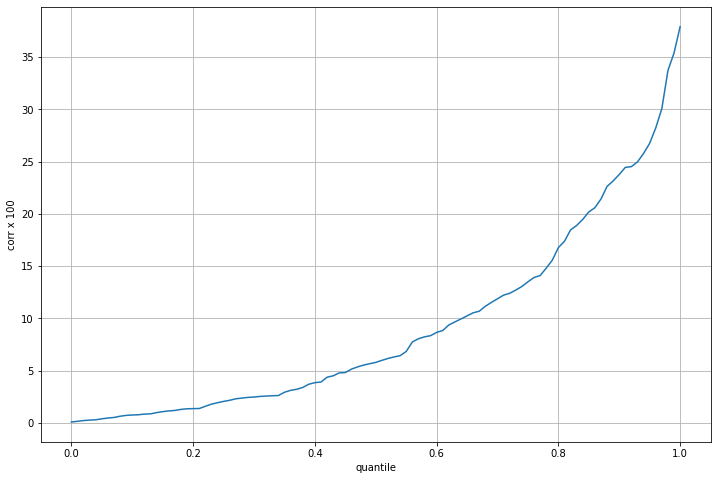

In [14]:
plt.figure(figsize=(12,8))
(100*corrs_df.r_abs).quantile(np.arange(0,1.01,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("corr x 100")
plt.grid()
plt.show()

***